In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from glob import glob

In [2]:
TARGET_FEATURE = "TF-IDF given the whole Title"

## Load csv Files

In [3]:
glob_path = "../tools/*.csv"

dfs = {}
for path in glob(glob_path):
    year = path.split('/')[-1].split('.csv')[0].split('_')[-1]
    dfs[year] = pd.read_csv(path)


## Prepare materials

In [4]:
string_set_year = dict()
string_list_year = dict()
string_counter_year = dict()

# 딕셔너리를 순회하며 각 문자열을 분리하고 집합에 추가하며 빈도를 계산
for key, value in dfs.items():
    string_set = set()
    string_list = list()
    string_counter = Counter()
    for string in value[TARGET_FEATURE]:
        items = string.split(', ')
        for item in items:
            string_set.add(item)
            string_list.append(item)
            string_counter[item] += 1
    string_set_year[key] = string_set
    string_list_year[key] = string_list
    string_counter_year[key] = string_counter

In [5]:
dfs[key][TARGET_FEATURE].iloc[1]

'episodic, curriculum, agents, cross, transformer, 000, 100x, 10m, 128k, 130'

## plot topK most common elements

In [6]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{:.1f}%\n({:d})'.format(pct, val)
    return my_autopct

year:2018, unique/total: 1990/10090
year:2019, unique/total: 2499/14260
year:2020, unique/total: 2989/18920
year:2021, unique/total: 3442/23200
year:2022, unique/total: 4276/28200
year:2023, unique/total: 5133/35380


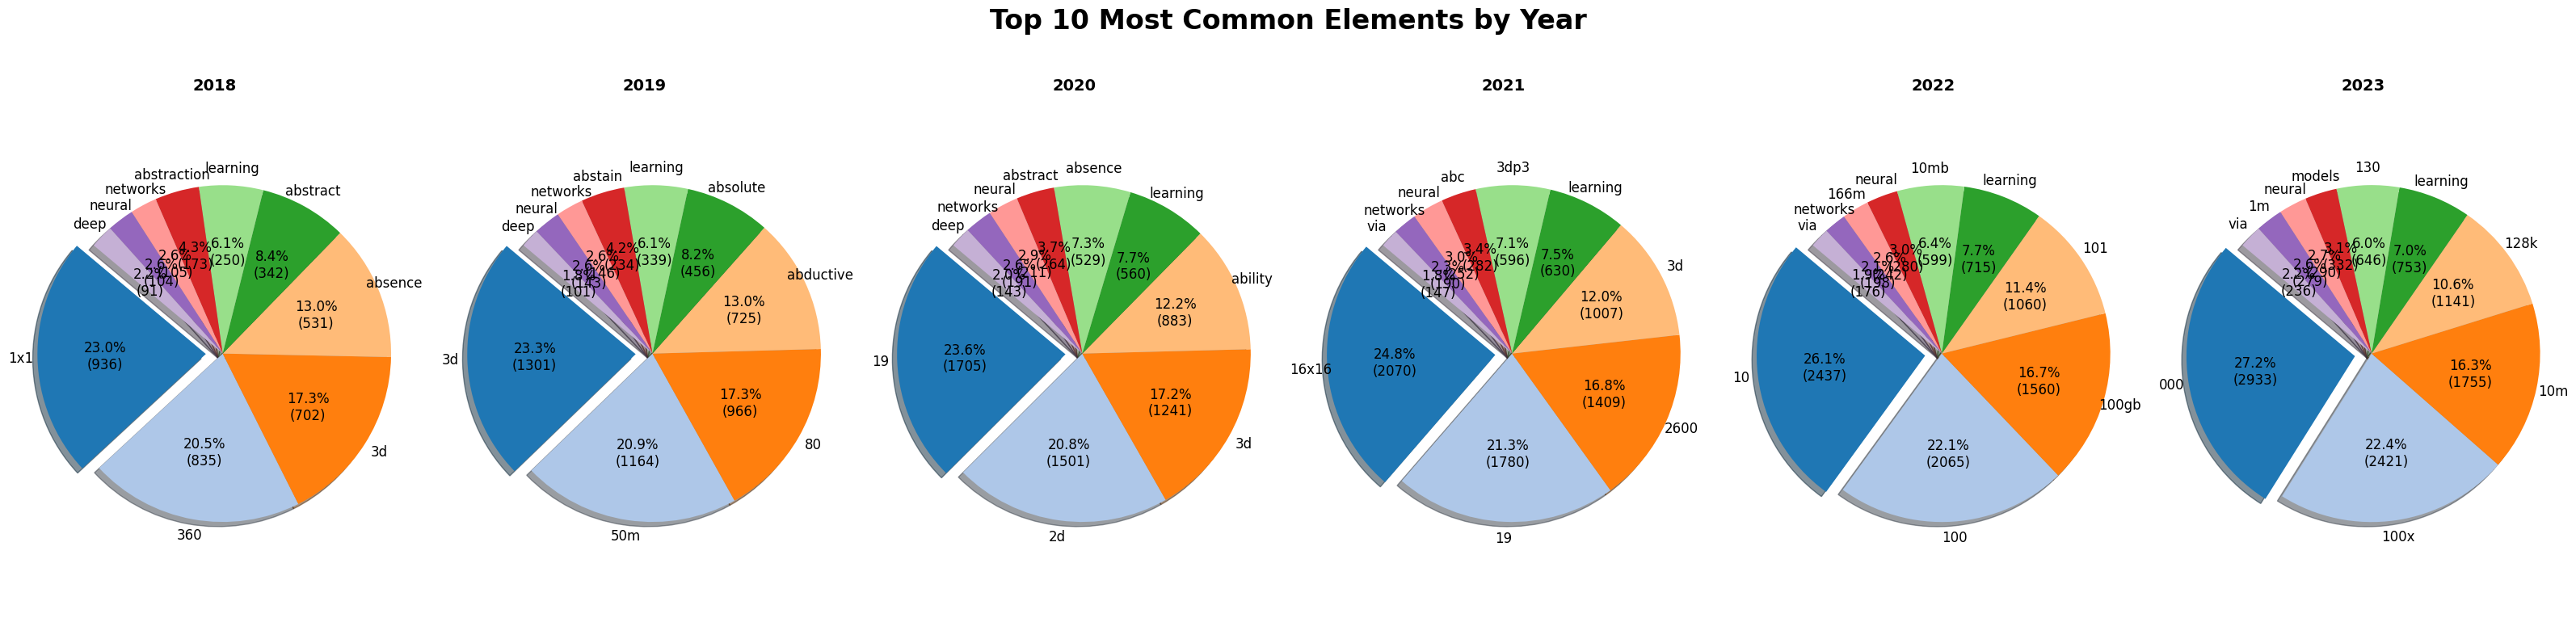

In [7]:
# 가장 많이 등장한 문자열 top k와 파이 그래프 생성
k = 10  # 원하는 상위 k개
num_years = len(string_counter_year)
fig, axs = plt.subplots(1, num_years, figsize=(32, 8))  # 1행 num_years열의 서브플롯 생성

for i, (year, string_counter) in enumerate(string_counter_year.items()):
    # 전체 문자열 요소 개수
    total_elements = sum(string_counter.values())
    # 유일한 문자열 요소 개수
    unique_elements = len(string_set_year[year])

    print(f"year:{year}, unique/total: {unique_elements}/{total_elements}")
    # 가장 많이 등장한 문자열 top k
    most_common_elements = string_counter.most_common(k)

    # 파이 그래프 생성
    labels, sizes = zip(*most_common_elements)
    colors = plt.cm.tab20(range(len(labels)))  # 색상 팔레트
    explode = [0.1 if i == 0 else 0 for i in range(len(labels))]  # 첫 번째 조각만 돌출
    
    wedges, texts, autotexts = axs[i].pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=140, colors=colors, explode=explode, shadow=True)
    
    # 레이블을 그래프 밖으로 빼기
    for text in texts:
        text.set_fontsize(12)
        text.set_rotation_mode('anchor')
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_color('black')

    axs[i].set_title(f"{year}", fontsize=14, fontweight='bold')
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# 전체 제목 설정
plt.suptitle(f"Top {k} Most Common Elements by Year", fontsize=24, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 레이아웃 조정

# 그래프 저장 및 출력
# plt.savefig(f"top_{k}_elements_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

#### 추출한 연도별 키워드에 대해서 tf-idf를 계산하고 출력

In [8]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
def calculate_tfidf(text):
    """
    Calculate TF-IDF scores for each word in the text and return a dictionary of words and their TF-IDF scores.
    """
    # Check if the input text is empty or contains only stop words
    if not isinstance(text, list):
        if not text.strip():
            raise ValueError("The input text is empty.")
        docs = [text]
    else:
        docs = text

    # TF-IDF vectorization
    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words("english"))

    tfidf_matrix = tfidf_vectorizer.fit_transform(docs)

    # Check if the resulting matrix is empty
    if tfidf_matrix.shape[1] == 0:
        raise ValueError("The input text contains only stop words or no valid words for TF-IDF calculation.")

    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Create a dictionary of words and their TF-IDF scores
    word_tfidf = [{word: score for word, score in zip(feature_names, tfidf_matrix.toarray()[idx])}
                  for idx, _ in enumerate(docs)]

    return word_tfidf

In [10]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /home/chpark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chpark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# Convert keys to a list
keys_list = list(string_list_year.keys())
print(keys_list)  # Output: ['a', 'b', 'c']

# Convert each set to a space-separated string and create a list
values_list = [' '.join(list(v)) for k, v in string_list_year.items()]
print(values_list)  # Output: [1, 2, 3]


word_tfidf_abstracts = calculate_tfidf(values_list)

TOP_K = 50
key_words_dict = dict()
for key, tfidf_dict in zip(keys_list, word_tfidf_abstracts):
    key_words = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:TOP_K]
    key_words = {word: tfidf for word, tfidf in key_words}
    key_words_dict[key] = key_words

['2018', '2019', '2020', '2021', '2022', '2023']
['synthesized tasks across environments policies adaptation transfer 1x1 360 3d 360 spatial audio self video supervised generation 1x1 3d absence gmms gans 1x1 360 3d absence abstract abstraction accelerated acceleration adaptively instance style normalization batch invariant neural networks 1x1 360 subtask dependencies hierarchical zero shot generalization reinforcement learning 1x1 360 kdgan distillation knowledge generative adversarial networks 1x1 360 3d absence contour location leveraging sources entropy reduction multiple information via 1x1 surrogate losses margin contextual bandits bounds algorithms efficient 1x1 360 towards representation adaptive sampling fast graph learning 1x1 360 3d analytic elastic lasso solution phase stationary net approximation bayesian 1x1 identification effects dependent causal estimation data 1x1 360 3d absence satisfaction streamlining constraint problems inference variational 1x1 360 3d absence adve

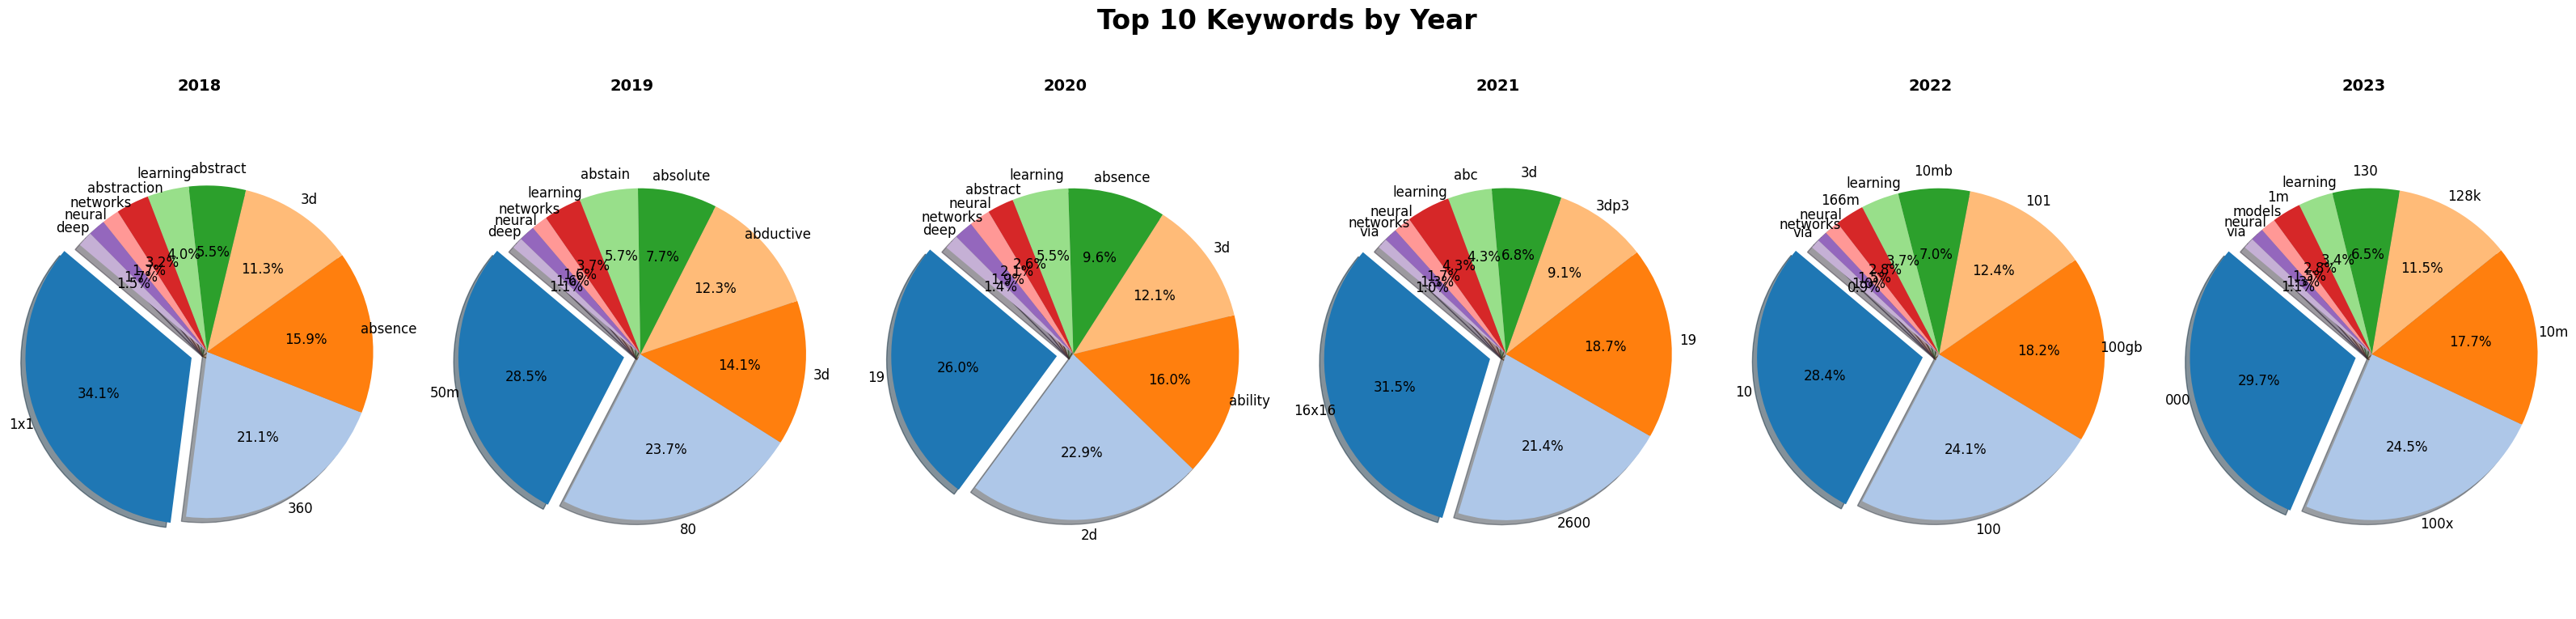

In [12]:
# top k 설정
k = 10

# 연도별 top k 키워드 추출
top_keywords_year = {}
for year, keywords in key_words_dict.items():
    counter = Counter(keywords)
    top_keywords = counter.most_common(k)
    top_keywords_year[year] = top_keywords

# 그래프 설정
num_years = len(key_words_dict)
fig, axs = plt.subplots(1, num_years, figsize=(32, 8))

# 색상 설정
colors = plt.cm.tab20(range(k))  # 색상 팔레트

# 각 연도별 파이 그래프 그리기
for i, (year, top_keywords) in enumerate(top_keywords_year.items()):
    labels, sizes = zip(*top_keywords)
    explode = [0.1 if idx == 0 else 0 for idx in range(k)]  # 첫 번째 조각만 돌출
    
    wedges, texts, autotexts = axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
    
    # 레이블 설정
    for text in texts:
        text.set_fontsize(12)
        text.set_rotation_mode('anchor')
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_color('black')
    
    axs[i].set_title(f"{year}", fontsize=14, fontweight='bold')
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# 전체 제목 설정
plt.suptitle(f"Top {k} Keywords by Year", fontsize=24, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 레이아웃 조정

# 그래프 출력
plt.show()

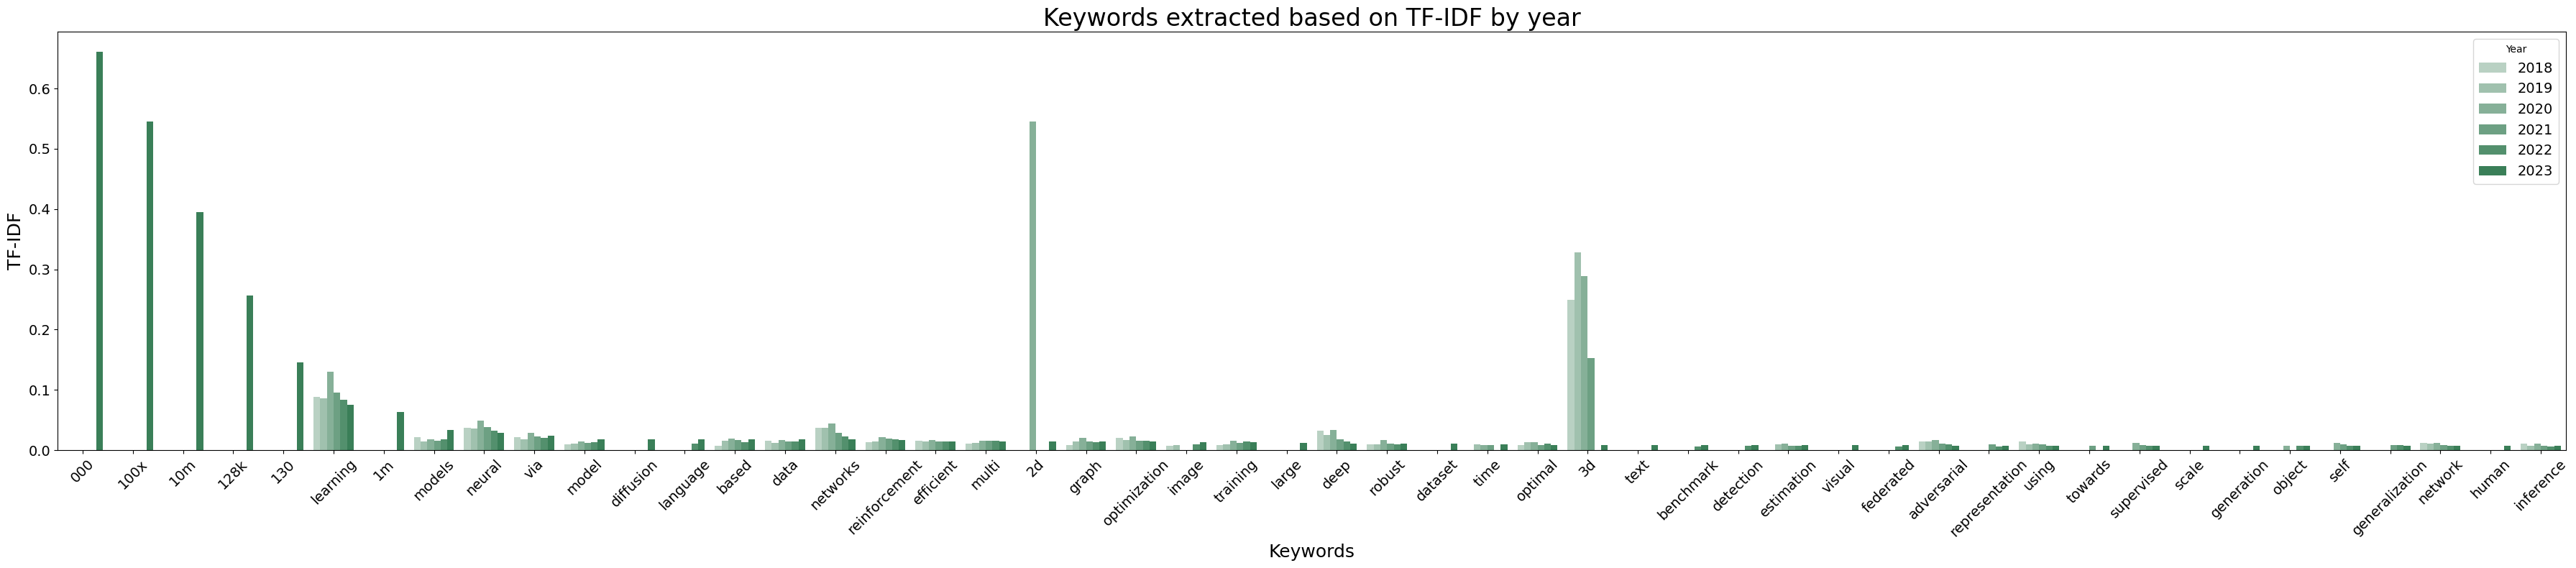

In [13]:
sorting_standard = "2023"
topk = 100

# Sorting keywords based on 2023 data
keywords_sorted = sorted(key_words_dict[sorting_standard], key=key_words_dict[sorting_standard].get, reverse=True)
top_keywords = keywords_sorted[:topk]

# Creating a DataFrame for Seaborn plotting
data = {'Year': [], 'Keyword': [], 'TF-IDF': []}
for year, year_data in key_words_dict.items():
    for keyword in top_keywords:
        data['Year'].append(year)
        data['Keyword'].append(keyword)
        data['TF-IDF'].append(year_data.get(keyword, 0))

df = pd.DataFrame(data)

# Generate a color palette
palette = sns.light_palette("seagreen", reverse=True, n_colors=8)[:len(key_words_dict)][::-1]

# Plotting with Seaborn
plt.figure(figsize=(36, 8))
sns.barplot(x='Keyword', y='TF-IDF', hue='Year', data=df, palette=palette)
plt.title(f'Keywords extracted based on TF-IDF by year', fontsize=24)
plt.xlabel('Keywords', fontsize=18)
plt.ylabel('TF-IDF', fontsize=18)
plt.xticks(rotation=45, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.legend(title='Year', fontsize=14)
plt.show()